 В каждом поселении есть таверна, в которой разливают вкусный эль и пекут замечательные булочки. Не смотря на все свои светлые качества, гномы достаточно забывчивые и расторопные, поэтому после завершения домашних дел перед ужином в таверне забывают кошелек, а расплачиваются утром на следующий день.

Особо нечестные жители общины могут и вовсе не вернуть деньги заведению, поэтому любители гномьего Машинного Обучения предложили следующую идею: **научиться предсказывать, вернет ли забывший дома кошелек гном деньги в течение ближайших дней или, на современном языке, его заказ дефолтнет.** Это позволит повысить финансовую стабильность таверны, не исполняя заказы, которые заранее не будут оплачены.

Ваша задача - *построить алгоритм, определяющий вероятность дефолта* того или иного заказа на исторических данных из таверн различных гномьих общин с 2015-02-24 по 2016-09-30.

In [114]:
import pandas as pd
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

In [115]:
df = pd.read_csv('train_inter.csv')

In [116]:
#здесь файл с тестовыми данными без таргетной переменной, для них система будет считать по нашей модели ROC_AUC
df_t = pd.read_csv('test_inter.csv')

In [117]:
df.shape, df_t.shape

((3168, 19), (989, 18))

In [118]:
df[:2]

,Deal_id,Deal_date,First_deal_date,Secret_dwarf_info_1,Secret_dwarf_info_2,Secret_dwarf_info_3,First_default_date,Successful_deals_count,Region,Tavern,Hashed_deal_detail_1,Hashed_deal_detail_2,Hashed_deal_detail_3,Hashed_deal_detail_4,Hashed_deal_detail_5,Hashed_deal_detail_6,Age,Gender,Default
0,22487461,2015-11-05,2015-08-29,NaN,NaN,NaN,NaN,0.0,Tavern_district_3,7,2.5,-3,8,2.5,-3,5,36.0,Male,0
1,62494261,2016-08-26,2015-12-21,3.5,-2.0,5.0,2016-07-30,2.0,Tavern_district_4,7,2.5,-3,14,3.5,-3,5,29.0,Female,1


In [119]:
df.columns

Index(['Deal_id', 'Deal_date', 'First_deal_date', 'Secret_dwarf_info_1',
       'Secret_dwarf_info_2', 'Secret_dwarf_info_3', 'First_default_date',
       'Successful_deals_count', 'Region', 'Tavern', 'Hashed_deal_detail_1',
       'Hashed_deal_detail_2', 'Hashed_deal_detail_3', 'Hashed_deal_detail_4',
       'Hashed_deal_detail_5', 'Hashed_deal_detail_6', 'Age', 'Gender',
       'Default'],
      dtype='object')

In [120]:
df.isna().sum()[df.isna().sum() > 0]

Secret_dwarf_info_1       2633
Secret_dwarf_info_2       2633
Secret_dwarf_info_3       2633
First_default_date        2633
Successful_deals_count      14
Region                       7
dtype: int64

#### Заполним пропуски в некоторых числовых колонках

In [121]:
def nan_values(df):
    mean_value = ['Secret_dwarf_info_1', 'Secret_dwarf_info_2', 'Secret_dwarf_info_3']
    for i in mean_value:
        df[i].fillna(value = df[i].mean(), inplace = True)
        
    df['Region'].fillna(df.Region.mode()[0], inplace = True)
    df['Successful_deals_count'].fillna(0, inplace = True)
    return df

df = nan_values(df)
df_t = nan_values(df_t)

#### Поработаем с датами

In [122]:
df['First_default_date'] = pd.to_datetime(df['First_default_date'])
df['First_deal_date'] = pd.to_datetime(df['First_deal_date'])
df['Deal_date'] = pd.to_datetime(df['Deal_date'])

In [123]:
df_t['First_default_date'] = pd.to_datetime(df_t['First_default_date'])
df_t['First_deal_date'] = pd.to_datetime(df_t['First_deal_date'])
df_t['Deal_date'] = pd.to_datetime(df_t['Deal_date'])

In [124]:
data = pd.DataFrame(df['First_default_date'].value_counts().values, index = df['First_default_date'].value_counts().index)\
                                                                        .reset_index()
data.rename(columns = {0:'count'}, inplace = True)

<AxesSubplot:title={'center':'Count across time'}>

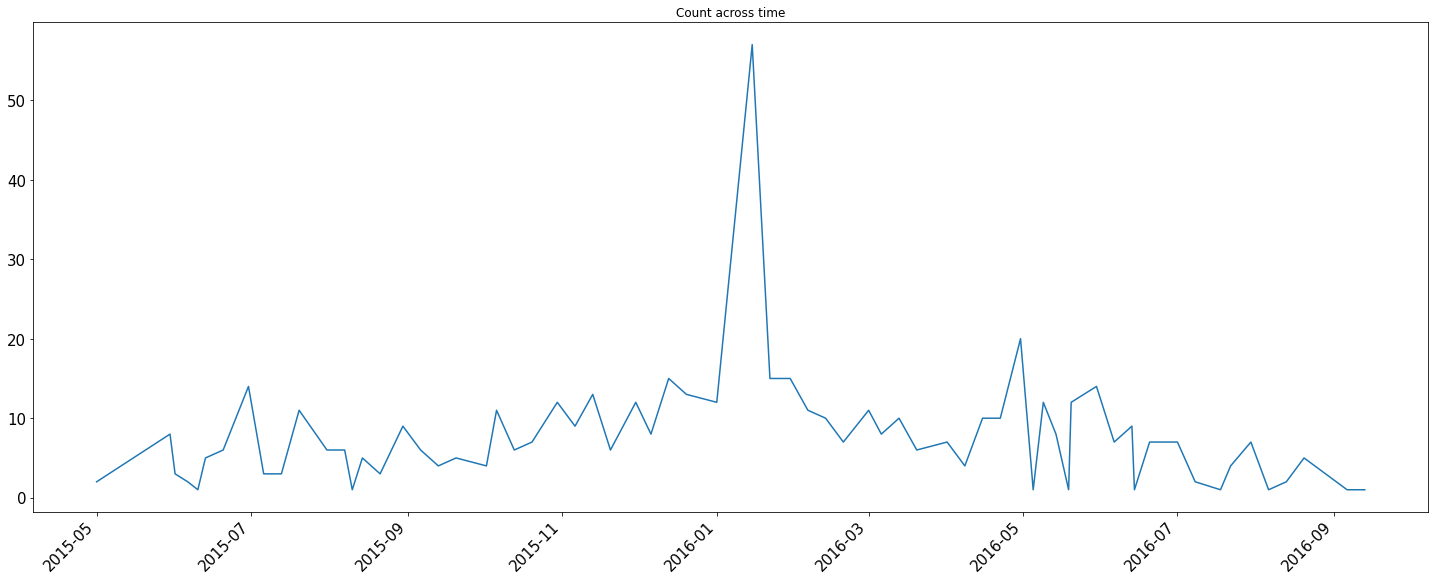

In [125]:
data.plot(x='index', y='count', kind='line', rot=45, legend=None, 
        title='Count across time', xlabel='', fontsize=15, figsize=(25,10))

In [126]:
df['First_default_date'].min(), df['First_default_date'].max()

(Timestamp('2015-05-01 00:00:00'), Timestamp('2016-09-13 00:00:00'))

In [127]:
def nan_data(df):
    min_date = df['First_default_date'].min()
    fil_dat = min_date - pd.Timedelta(days = 365)
    df['First_default_date'].fillna(fil_dat, inplace = True)
    

    
    df['First_default_date_day'] = df['First_default_date'].apply(lambda x:x.day)
    df['First_default_date_month'] = df['First_default_date'].apply(lambda x:x.month)
    df['First_default_date_year'] = df['First_default_date'].apply(lambda x:x.year)

    df['First_deal_date_day'] = df['First_deal_date'].apply(lambda x:x.day)
    df['First_deal_date_month'] = df['First_deal_date'].apply(lambda x:x.month)
    df['First_deal_date_year'] = df['First_deal_date'].apply(lambda x:x.year)

    df['Deal_date_day'] = df['Deal_date'].apply(lambda x:x.day)
    df['Deal_date_month'] = df['Deal_date'].apply(lambda x:x.month)
    df['Deal_date_year'] = df['Deal_date'].apply(lambda x:x.year)
    
    return df

df = nan_data(df)
df_t = nan_data(df_t)

#### Преобразуем категориальный признаки

In [128]:
obj_columns = df.loc[:, df.dtypes == np.object].columns
obj_columns

C:\Users\Admin\AppData\Local\Temp/ipykernel_19544/1324369251.py:1: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  obj_columns = df.loc[:, df.dtypes == np.object].columns


Index(['Region', 'Gender'], dtype='object')

In [129]:
### Преобразуем категориальные колонки
def nan_kateg(df):
    for col in obj_columns:

        if df[col].nunique() < 10:
            one_hot = pd.get_dummies(df[col], prefix=col, drop_first = True)
            df = pd.concat((df.drop(col, axis=1), one_hot), axis=1)

        else:
            obj_mean = df.groupby(col).agg({'Default':'mean'}).squeeze()
            df[col] = df[col].map(obj_mean)
            
    return df

df = nan_kateg(df)
df_t = nan_kateg(df_t)

In [130]:
#с этих столбцов уже получили всю необ инфу
df.drop(['Deal_date', 'First_deal_date', 'First_default_date'], axis = 1, inplace = True)
df_t.drop(['Deal_date', 'First_deal_date', 'First_default_date'], axis = 1, inplace = True)

In [131]:
df.head()

,Deal_id,Secret_dwarf_info_1,Secret_dwarf_info_2,Secret_dwarf_info_3,Successful_deals_count,Tavern,Hashed_deal_detail_1,Hashed_deal_detail_2,Hashed_deal_detail_3,Hashed_deal_detail_4,...,Deal_date_month,Deal_date_year,Region_Tavern_district_1,Region_Tavern_district_2,Region_Tavern_district_3,Region_Tavern_district_4,Region_Tavern_district_5,Region_Tavern_district_6,Region_Tavern_district_7,Gender_Male
0,22487461,3.935514,-2.299065,5.26729,0.0,7,2.5,-3,8,2.5,...,11,2015,0,0,1,0,0,0,0,1
1,62494261,3.500000,-2.000000,5.00000,2.0,7,2.5,-3,14,3.5,...,8,2016,0,0,0,1,0,0,0,0
2,34822849,3.935514,-2.299065,5.26729,0.0,7,2.5,-3,8,2.5,...,2,2016,0,0,0,0,0,1,0,0
3,46893387,3.935514,-2.299065,5.26729,0.0,13,2.5,-2,5,2.5,...,4,2016,0,1,0,0,0,0,0,0
4,67128275,3.935514,-2.299065,5.26729,0.0,39,2.5,-3,7,2.5,...,9,2016,0,0,0,1,0,0,0,0


### Начнём обучение

Начнём с RandomForestClassifier()

In [132]:
X = df.drop(['Default', 'Deal_id'], axis = 1)
y = df['Default']

In [133]:
X_t = df_t.drop(['Deal_id'], axis = 1)

In [134]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0, stratify = y)

In [135]:
X_train.shape, X_test.shape

((2534, 29), (634, 29))

In [215]:
pipe_rf = Pipeline([('clf', RandomForestClassifier(random_state = 0))])
pipe_rf.fit(X_train, y_train)

Pipeline(steps=[('clf', RandomForestClassifier(random_state=0))])

In [216]:
y_pred = pipe_rf.predict(X_test)

#### Macro average

При макро усреднении мы для каждой модели считаем индивидуальные метрики, которые заранее не чувствительны к размеру классов. То есть, используемые индивидуально метрики не чувствительны к дисбалансу. Каждый класс, независимо от размера, одинаково важен для среднего замера.
<div>
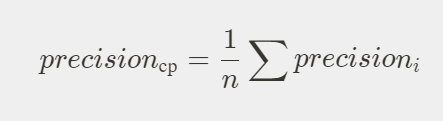
</div>

weighted average is precision of all classes merge together.   
weighted average = (TP of class 0 + TP of class 1)/(total number of class 0 + total number of class 1 

In [217]:
print(classification_report(y_test, y_pred, digits = 4))


              precision    recall  f1-score   support

           0     0.8906    0.9965    0.9406       564
           1     0.3333    0.0143    0.0274        70

    accuracy                         0.8880       634
   macro avg     0.6120    0.5054    0.4840       634
weighted avg     0.8291    0.8880    0.8398       634



In [ ]:
res_rf = pd.DataFrame({'Deal_id': df_t['Deal_id'],'Prediction': rf.predict_proba(X_t)[:,1]})
res_rf[:3]

#### Посчитанный системой ROC_AUC: 0.701

In [ ]:
res_rf.to_csv('prediction_rf.csv', index = False)

### Настроим гиперпараметры

In [139]:
n_estimators = np.linspace(30, 420, num = 4).astype(int)#array([ 30., 160., 290., 420.])
max_depth = np.linspace(10, 50, num = 5).astype(int)#array([10., 20., 30., 40., 50.])

param_grid = {"clf__n_estimators":n_estimators,
             "clf__max_depth":max_depth}

In [140]:
search = GridSearchCV(pipe_rf, param_grid, scoring = "f1_macro", cv =3, verbose = 3)

In [141]:
search.fit(X_train, y_train)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV 1/3] END clf__max_depth=10, clf__n_estimators=30;, score=0.479 total time=   0.0s
[CV 2/3] END clf__max_depth=10, clf__n_estimators=30;, score=0.490 total time=   0.0s
[CV 3/3] END clf__max_depth=10, clf__n_estimators=30;, score=0.513 total time=   0.0s
[CV 1/3] END clf__max_depth=10, clf__n_estimators=160;, score=0.470 total time=   0.2s
[CV 2/3] END clf__max_depth=10, clf__n_estimators=160;, score=0.492 total time=   0.2s
[CV 3/3] END clf__max_depth=10, clf__n_estimators=160;, score=0.481 total time=   0.2s
[CV 1/3] END clf__max_depth=10, clf__n_estimators=290;, score=0.470 total time=   0.4s
[CV 2/3] END clf__max_depth=10, clf__n_estimators=290;, score=0.470 total time=   0.4s
[CV 3/3] END clf__max_depth=10, clf__n_estimators=290;, score=0.482 total time=   0.4s
[CV 1/3] END clf__max_depth=10, clf__n_estimators=420;, score=0.470 total time=   0.6s
[CV 2/3] END clf__max_depth=10, clf__n_estimators=420;, score=0.491 tota

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('clf', RandomForestClassifier())]),
             param_grid={'clf__max_depth': array([10, 20, 30, 40, 50]),
                         'clf__n_estimators': array([ 30, 160, 290, 420])},
             scoring='f1_macro', verbose=3)

In [147]:
search.best_score_, search.best_estimator_

(0.5212927495388722,
 Pipeline(steps=[('clf', RandomForestClassifier(max_depth=20, n_estimators=30))]))

#### F1_macro стало меньше по сравнению с  RF без параметров
Было 0.5101

In [149]:
search.score(X_test, y_test)

0.4833627597446692

In [150]:
y_prob_train = search.predict_proba(X_train)[:, 1]
y_prob_test = search.predict_proba(X_test)[:, 1]

Text(0.5, 1.0, 'Train Precision-Recall curve')

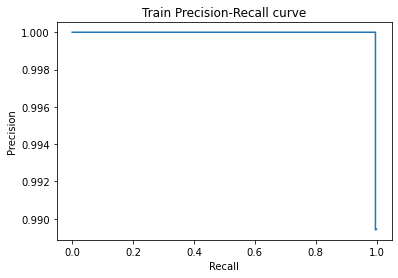

In [151]:
precision, recall, thresholds = precision_recall_curve(y_train, y_prob_train)
plt.plot(recall, precision)
plt.ylabel("Precision")
plt.xlabel("Recall")
plt.title("Train Precision-Recall curve")

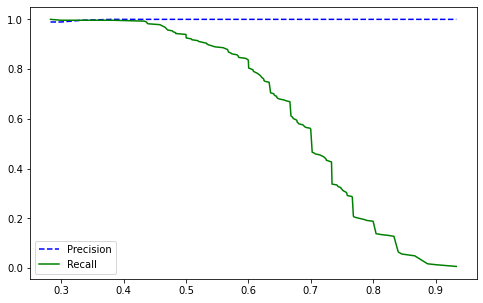

In [152]:
def plot_precision_recall_vs_threshold(precisions, recall, thresholds): 
    fig = plt.figure(figsize= (8,5))
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recall[:-1], "g-", label="Recall")
    plt.legend()

plot_precision_recall_vs_threshold(precision, recall, thresholds)

In [153]:
res = pd.DataFrame({'Deal_id': df_t['Deal_id'],'Prediction': search.predict_proba(X_t)[:,1]})

In [154]:
res.to_csv('prediction.csv', index = False)

#### Посчитанный системой ROC_AUC:  0.627

In [177]:
df = pd.read_csv('prediction.csv')
df[:3]

,Deal_id,Prediction
0,72875713,0.233333
1,75825544,0.233333
2,81809181,0.207843


### Попробуем обучить SVM

In [161]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler

svm = Pipeline([('scaler', StandardScaler()), ('svm', SVC(probability = True))])
svm.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()), ('svm', SVC(probability=True))])

In [162]:
prediction = svm.predict(X_test)

In [163]:
print(classification_report(y_test, prediction, digits = 5))

              precision    recall  f1-score   support

           0    0.88959   1.00000   0.94157       564
           1    0.00000   0.00000   0.00000        70

    accuracy                        0.88959       634
   macro avg    0.44479   0.50000   0.47078       634
weighted avg    0.79137   0.88959   0.83761       634



C:\Users\Admin\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [193]:
%%time
# defining parameter range
param_grid = {'svm__C': [0.1, 1, 10, 100], 
              'svm__gamma': [1, 0.1, 0.01, 0.001],
              'svm__kernel': ['poly', 'rbf', 'sigmoid'] }

#['poly', 'rbf', 'sigmoid'
grid = GridSearchCV(svm, param_grid, scoring = "f1_macro", cv = 3, refit = True, verbose = 3)
  
# fitting the model for grid search
grid.fit(X_train, y_train)

Fitting 3 folds for each of 48 candidates, totalling 144 fits
[CV 1/3] END svm__C=0.1, svm__gamma=1, svm__kernel=poly;, score=0.539 total time=   0.4s
[CV 2/3] END svm__C=0.1, svm__gamma=1, svm__kernel=poly;, score=0.530 total time=   0.5s
[CV 3/3] END svm__C=0.1, svm__gamma=1, svm__kernel=poly;, score=0.529 total time=   0.6s
[CV 1/3] END svm__C=0.1, svm__gamma=1, svm__kernel=rbf;, score=0.471 total time=   1.0s
[CV 2/3] END svm__C=0.1, svm__gamma=1, svm__kernel=rbf;, score=0.471 total time=   0.9s
[CV 3/3] END svm__C=0.1, svm__gamma=1, svm__kernel=rbf;, score=0.471 total time=   0.9s
[CV 1/3] END svm__C=0.1, svm__gamma=1, svm__kernel=sigmoid;, score=0.516 total time=   0.3s
[CV 2/3] END svm__C=0.1, svm__gamma=1, svm__kernel=sigmoid;, score=0.487 total time=   0.3s
[CV 3/3] END svm__C=0.1, svm__gamma=1, svm__kernel=sigmoid;, score=0.526 total time=   0.2s
[CV 1/3] END svm__C=0.1, svm__gamma=0.1, svm__kernel=poly;, score=0.517 total time=   0.2s
[CV 2/3] END svm__C=0.1, svm__gamma=0.1,

[CV 1/3] END svm__C=10, svm__gamma=0.01, svm__kernel=poly;, score=0.468 total time=   0.2s
[CV 2/3] END svm__C=10, svm__gamma=0.01, svm__kernel=poly;, score=0.469 total time=   0.2s
[CV 3/3] END svm__C=10, svm__gamma=0.01, svm__kernel=poly;, score=0.481 total time=   0.2s
[CV 1/3] END svm__C=10, svm__gamma=0.01, svm__kernel=rbf;, score=0.478 total time=   0.4s
[CV 2/3] END svm__C=10, svm__gamma=0.01, svm__kernel=rbf;, score=0.499 total time=   0.5s
[CV 3/3] END svm__C=10, svm__gamma=0.01, svm__kernel=rbf;, score=0.488 total time=   0.4s
[CV 1/3] END svm__C=10, svm__gamma=0.01, svm__kernel=sigmoid;, score=0.512 total time=   0.3s
[CV 2/3] END svm__C=10, svm__gamma=0.01, svm__kernel=sigmoid;, score=0.489 total time=   0.3s
[CV 3/3] END svm__C=10, svm__gamma=0.01, svm__kernel=sigmoid;, score=0.488 total time=   0.2s
[CV 1/3] END svm__C=10, svm__gamma=0.001, svm__kernel=poly;, score=0.471 total time=   0.1s
[CV 2/3] END svm__C=10, svm__gamma=0.001, svm__kernel=poly;, score=0.471 total time

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('svm', SVC(probability=True))]),
             param_grid={'svm__C': [0.1, 1, 10, 100],
                         'svm__gamma': [1, 0.1, 0.01, 0.001],
                         'svm__kernel': ['poly', 'rbf', 'sigmoid']},
             scoring='f1_macro', verbose=3)

In [194]:

# print best parameter after tuning
print(grid.best_params_)
  
# print how our model looks after hyper-parameter tuning
print(grid.best_estimator_)

{'svm__C': 10, 'svm__gamma': 0.1, 'svm__kernel': 'poly'}
Pipeline(steps=[('scaler', StandardScaler()),
                ('svm', SVC(C=10, gamma=0.1, kernel='poly', probability=True))])


In [195]:
grid_predictions = grid.predict(X_test)
  
# print classification report
print(classification_report(y_test, grid_predictions, digits = 5))

              precision    recall  f1-score   support

           0    0.90248   0.90248   0.90248       564
           1    0.21429   0.21429   0.21429        70

    accuracy                        0.82650       634
   macro avg    0.55838   0.55838   0.55838       634
weighted avg    0.82650   0.82650   0.82650       634



In [220]:
grid.score(X_test, y_test)

0.5583839918946302

In [185]:
res_svc = pd.DataFrame({'Deal_id': df_t['Deal_id'],'Prediction': grid.predict_proba(X_t)[:,1]})#0.497
res_svc[:3]

,Deal_id,Prediction
0,72875713,0.118006
1,75825544,0.088163
2,81809181,0.103189


#### Посчитанный системой ROC_AUC: 0.552

In [181]:
res_svc.to_csv('prediction_svc.csv', index = False)

Вывод:Видим, что RandomForest() с параметрами по умполчанию показывает наилучшее качество на валидационной выборке: 0.701